In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytensor
pytensor.config.exception_verbosity = 'high'
pytensor.config.mode == 'NUMBA'
pytensor.config.cxx = "" 

In [3]:
import pandas as pd
import numpy as np

# Example: Create synthetic MFF data
np.random.seed(42)
n_weeks = 104  # 2 years of weekly data

# Generate dates
dates = pd.date_range("2023-01-01", periods=n_weeks, freq="W")

# Build MFF records
records = []

# KPI: Sales (weekly)
for i, date in enumerate(dates):
    base_sales = 1000 + 50 * np.sin(2 * np.pi * i / 52)  # Seasonality
    noise = np.random.normal(0, 50)
    records.append({
        "Period": date,
        "VariableName": "Sales",
        "VariableValue": base_sales + noise
    })

# Media: TV spend (weekly, with some weeks at zero)
for i, date in enumerate(dates):
    spend = np.random.exponential(500) if np.random.random() > 0.2 else 0
    records.append({
        "Period": date,
        "VariableName": "TV",
        "VariableValue": spend
    })

# Media: Digital spend (weekly)
for i, date in enumerate(dates):
    spend = np.random.exponential(300)
    records.append({
        "Period": date,
        "VariableName": "Digital",
        "VariableValue": spend
    })

# Control: Price Index
for i, date in enumerate(dates):
    price = 100 + np.random.normal(0, 5)
    records.append({
        "Period": date,
        "VariableName": "Price",
        "VariableValue": price
    })

# Create DataFrame
mff_data = pd.DataFrame(records)
mff_data[['Outlet', 'Product', 'Campaign', 'Geography', 'Creative']] = np.nan
print(f"MFF shape: {mff_data.shape}")
print(mff_data.head(10))

MFF shape: (416, 8)
      Period VariableName  VariableValue  Outlet  Product  Campaign  \
0 2023-01-01        Sales    1024.835708     NaN      NaN       NaN   
1 2023-01-08        Sales     999.113619     NaN      NaN       NaN   
2 2023-01-15        Sales    1044.350210     NaN      NaN       NaN   
3 2023-01-22        Sales    1093.881737     NaN      NaN       NaN   
4 2023-01-29        Sales    1011.528490     NaN      NaN       NaN   
5 2023-02-05        Sales    1016.696389     NaN      NaN       NaN   
6 2023-02-12        Sales    1112.116774     NaN      NaN       NaN   
7 2023-02-19        Sales    1075.797274     NaN      NaN       NaN   
8 2023-02-26        Sales    1017.675474     NaN      NaN       NaN   
9 2023-03-05        Sales    1071.400803     NaN      NaN       NaN   

   Geography  Creative  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3        NaN       NaN  
4        NaN       NaN  
5        NaN       NaN  
6        NaN       NaN 

In [4]:
from mmm_framework import (
    MFFConfigBuilder,
    ModelConfigBuilder,
    TrendConfig,
    TrendType,
    BayesianMMM,
    load_mff,
)

# Step 2a: Configure the data structure
mff_config = (
    MFFConfigBuilder()
    .with_kpi_name("Sales")                    # Target variable
    .add_national_media("TV", adstock_lmax=8)  # TV with 8-week carryover
    .add_national_media("Digital", adstock_lmax=4)  # Digital with 4-week carryover
    .add_price_control()                       # Price as control variable
    .build()
)

print(f"Media channels: {mff_config.media_names}")
print(f"Control variables: {mff_config.control_names}")

# Step 2b: Load and validate data
panel = load_mff(mff_data, mff_config)

print(f"\nPanel dataset:")
print(f"  Observations: {panel.n_obs}")
print(f"  Channels: {panel.n_channels}")
print(f"  Controls: {panel.n_controls}")

# Step 2c: Configure model inference
model_config = (
    ModelConfigBuilder()      # Use JAX-based sampler (4-10x faster)
    .with_chains(4)           # 4 parallel chains for convergence diagnostics
    .with_draws(2000)         # 2000 posterior draws
    .with_tune(1000)          # 1000 warmup iterations
    .with_target_accept(0.95)  # Target acceptance rate
    .build()
)

# Step 2d: Configure trend component
trend_config = TrendConfig(
    type=TrendType.LINEAR,
    growth_prior_sigma=0.1
)

Media channels: ['TV', 'Digital']
Control variables: ['Price']

Panel dataset:
  Observations: 104
  Channels: 2
  Controls: 1


In [5]:
model_config

ModelConfig(specification=<ModelSpecification.ADDITIVE: 'additive'>, inference_method=<InferenceMethod.BAYESIAN_NUMPYRO: 'bayesian_numpyro'>, n_chains=4, n_draws=2000, n_tune=1000, target_accept=0.95, hierarchical=HierarchicalConfig(enabled=True, pool_across_geo=True, pool_across_product=True, use_non_centered=True, non_centered_threshold=20, mu_prior=PriorConfig(distribution=<PriorType.NORMAL: 'Normal'>, params={'mu': 0.0, 'sigma': 1.0}, dims=None), sigma_prior=PriorConfig(distribution=<PriorType.HALF_NORMAL: 'HalfNormal'>, params={'sigma': 0.5}, dims=None)), seasonality=SeasonalityConfig(yearly=2, monthly=None, weekly=None), control_selection=ControlSelectionConfig(method='none', expected_nonzero=3, regularization=1.0), ridge_alpha=1.0, bootstrap_samples=1000, optim_maxiter=500, optim_seed=42)

In [6]:
# Build the model
mmm = BayesianMMM(panel, model_config, trend_config)

# Inspect model structure
print("Model parameters:")
for var in mmm.model.free_RVs:
    print(f"  {var.name}")

# Prior predictive check (ALWAYS do this before fitting)
print("\n=== Prior Predictive Check ===")
prior = mmm.sample_prior_predictive(samples=200)
y_prior = prior.prior["y_obs_scaled"].values.flatten()

print(f"Prior predictive y range: [{y_prior.min():.1f}, {y_prior.max():.1f}]")
print(f"Actual y range: [{panel.y.min():.1f}, {panel.y.max():.1f}]")

# Fit the model
print("\n=== Fitting Model ===")
results = mmm.fit(random_seed=42, target_accept=0.99)

# Convergence diagnostics (CRITICAL - check these!)
print("\n=== Diagnostics ===")
print(f"Divergences: {results.diagnostics['divergences']}")
print(f"R-hat max: {results.diagnostics['rhat_max']:.4f}")
print(f"ESS bulk min: {results.diagnostics['ess_bulk_min']:.0f}")

# Check for issues
if results.diagnostics['divergences'] > 0:
    print("⚠️  Divergences detected - consider reparameterization")
if results.diagnostics['rhat_max'] > 1.01:
    print("⚠️  R-hat > 1.01 - chains may not have converged")
if results.diagnostics['ess_bulk_min'] < 400:
    print("⚠️  Low ESS - consider more draws")

# Posterior summary with uncertainty
print("\n=== Posterior Summary ===")
summary = results.summary(["beta_TV", "beta_Digital", "sigma"])
print(summary[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]])

Sampling: [adstock_Digital, adstock_TV, beta_Digital, beta_TV, beta_controls, intercept, sat_lam_Digital, sat_lam_TV, season_yearly, sigma, trend_slope, y_obs]


Model parameters:
  intercept
  trend_slope
  season_yearly
  adstock_TV
  sat_lam_TV
  beta_TV
  adstock_Digital
  sat_lam_Digital
  beta_Digital
  beta_controls
  sigma

=== Prior Predictive Check ===
Prior predictive y range: [715.3, 1330.0]
Actual y range: [853.5, 1117.8]

=== Fitting Model ===


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)



=== Diagnostics ===
Divergences: 0
R-hat max: 1.0017
ESS bulk min: 3652

=== Posterior Summary ===
               mean     sd  hdi_3%  hdi_97%  r_hat
beta_TV       0.377  0.279   0.000    0.875    1.0
beta_Digital  0.329  0.261   0.000    0.800    1.0
sigma         0.775  0.055   0.677    0.879    1.0



=== Channel Contributions ===
Total TV contribution: 694
Total Digital contribution: 560


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

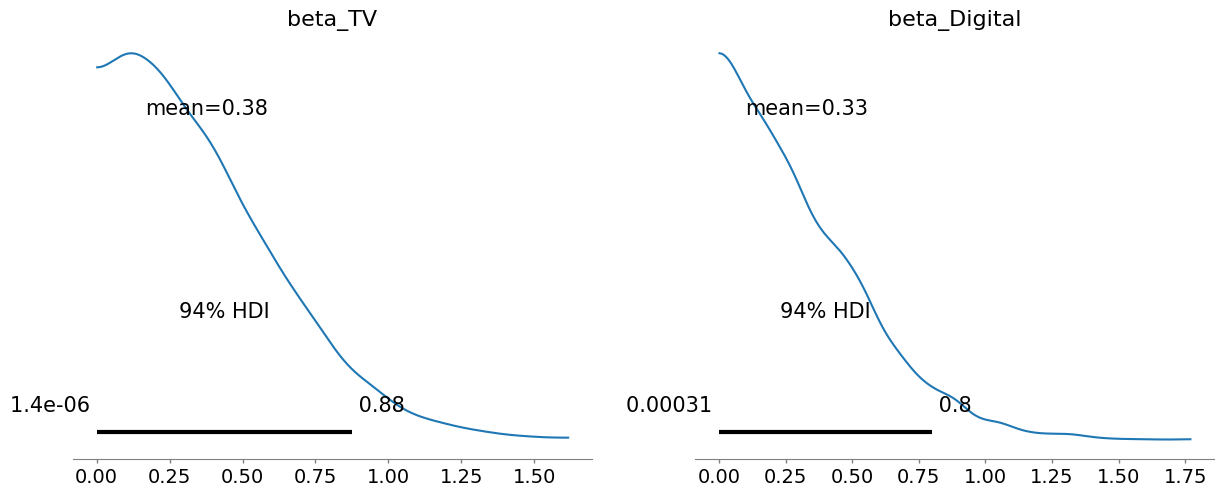

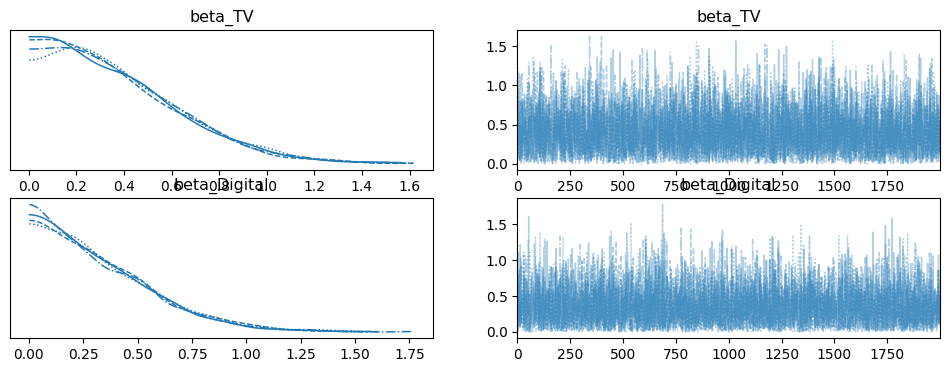

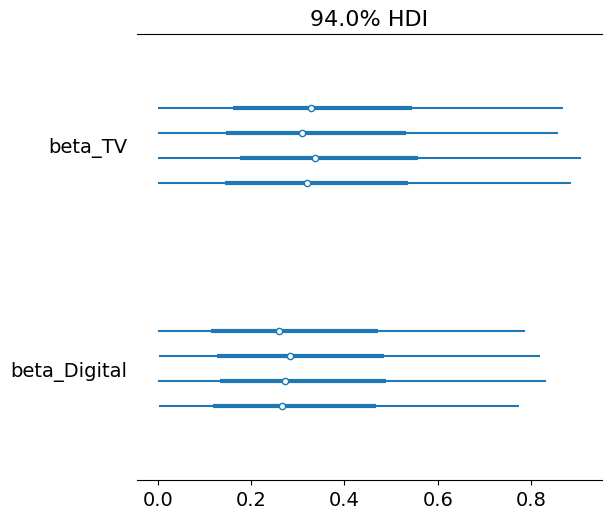

In [7]:
# Channel contributions with uncertainty
print("\n=== Channel Contributions ===")
if results.channel_contributions is not None:
    contrib = results.channel_contributions.sum()
    print(f"Total TV contribution: {contrib['TV']:.0f}")
    print(f"Total Digital contribution: {contrib['Digital']:.0f}")

# Access the full InferenceData object for ArviZ plots
import arviz as az

# Posterior distributions
az.plot_posterior(results.trace, var_names=["beta_TV", "beta_Digital"])

# Trace plots for convergence
az.plot_trace(results.trace, var_names=["beta_TV", "beta_Digital"])

# Forest plot comparing channels
az.plot_forest(results.trace, var_names=["beta_TV", "beta_Digital"])

In [25]:
from mmm_framework.reporting import MMMReportGenerator, ReportConfig, ReportBuilder
from mmm_framework.reporting.data_extractors import BayesianMMMExtractor

data = BayesianMMMExtractor(mmm, panel, results, ci_prob=0.9).extract()

# Option 1: Quick report from fitted model
report = MMMReportGenerator(
    model=mmm,
    data=data,
    panel=panel,
    results=results,
    config=ReportConfig(
        title="Marketing Mix Model Analysis",
        client="Acme Consumer Products",
        analysis_period="Jan 2023 - Dec 2025",
    ),
)

# Save to HTML
report.to_html("mmm_report_q4_2025.html")

# Option 2: Fluent builder pattern for customization
report = (
    ReportBuilder()
    .with_model(mmm, panel=panel, results=results)
    .with_data(data)
    .with_title("Q4 Marketing Analysis")
    .with_client("Acme Corp")
    .enable_section("decomposition")  # Ensure contributions shown
    .with_credible_interval(0.9)  # 90% credible intervals
    .enable_all_sections()
    .disable_section("diagnostics")  # Hide technical details
    .build()
)

report.to_html("executive_summary.html")

2026-01-11 00:46:26.686 | DEBUG    | mmm_framework.reporting.data_extractors:__init__:3 - Initializing BayesianMMMExtractor
2026-01-11 00:46:26.686 | DEBUG    | mmm_framework.reporting.data_extractors:extract:5 - Extracting data from BayesianMMM model
2026-01-11 00:46:26.686 | DEBUG    | mmm_framework.reporting.data_extractors:_get_channel_names:5 - Retrieving channel names from model
2026-01-11 00:46:26.686 | DEBUG    | mmm_framework.reporting.data_extractors:_get_dates:5 - Retrieving dates from panel data
2026-01-11 00:46:26.687 | DEBUG    | mmm_framework.reporting.data_extractors:_get_dates:10 - Using 'index' attribute from panel
2026-01-11 00:46:26.687 | DEBUG    | mmm_framework.reporting.data_extractors:_get_actual:5 - Retrieving actual values from model
2026-01-11 00:46:26.687 | DEBUG    | mmm_framework.reporting.data_extractors:_get_actual:8 - Unstandardizing actual values
2026-01-11 00:46:26.688 | DEBUG    | mmm_framework.reporting.data_extractors:extract:10 - Model appears to 

Output()

/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
2026-01-11 00:46:52.594 | DEBUG    | mmm_framework.reporting.data_extractors:_get_channel_names:5 - Retrieving channel names from model
2026-01-11 00:46:5

PosixPath('executive_summary.html')

In [9]:
data.channel_contribution?

Type:        NoneType
String form: None
Docstring:   <no docstring>

In [26]:
data = BayesianMMMExtractor(mmm, panel, results, ci_prob=0.9)

2026-01-11 00:58:35.476 | DEBUG    | mmm_framework.reporting.data_extractors:__init__:3 - Initializing BayesianMMMExtractor


In [27]:
data_bundle = data.extract()

2026-01-11 00:58:35.865 | DEBUG    | mmm_framework.reporting.data_extractors:extract:5 - Extracting data from BayesianMMM model
2026-01-11 00:58:35.865 | DEBUG    | mmm_framework.reporting.data_extractors:_get_channel_names:5 - Retrieving channel names from model
2026-01-11 00:58:35.865 | DEBUG    | mmm_framework.reporting.data_extractors:_get_dates:5 - Retrieving dates from panel data
2026-01-11 00:58:35.866 | DEBUG    | mmm_framework.reporting.data_extractors:_get_dates:10 - Using 'index' attribute from panel
2026-01-11 00:58:35.866 | DEBUG    | mmm_framework.reporting.data_extractors:_get_actual:5 - Retrieving actual values from model
2026-01-11 00:58:35.866 | DEBUG    | mmm_framework.reporting.data_extractors:_get_actual:8 - Unstandardizing actual values
2026-01-11 00:58:35.867 | DEBUG    | mmm_framework.reporting.data_extractors:extract:10 - Model appears to be fitted, extracting predictions and diagnostics
2026-01-11 00:58:35.867 | DEBUG    | mmm_framework.reporting.data_extracto

Output()

2026-01-11 00:58:59.927 | DEBUG    | mmm_framework.reporting.data_extractors:_compute_fit_statistics:4 - Computing fit statistics
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/redam94/mmm-framework/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
2026-01-11 00:59:01.632 

In [29]:
data._compute_marketing_attribution()

2026-01-11 00:59:34.545 | DEBUG    | mmm_framework.reporting.data_extractors:_compute_marketing_attribution:5 - Computing total marketing-attributed revenue
2026-01-11 00:59:34.545 | DEBUG    | mmm_framework.reporting.data_extractors:_compute_marketing_attribution:7 - Accessing model trace for attribution computation
2026-01-11 00:59:34.545 | DEBUG    | mmm_framework.reporting.data_extractors:_get_channel_names:5 - Retrieving channel names from model


In [31]:
contributions = mmm.compute_counterfactual_contributions()

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

In [40]:
contributions.summary()

,Channel,Total Contribution,Contribution %,HDI 3%,HDI 97%
0,TV,689.781537,55.196517,-903.025687,2759.896876
1,Digital,559.901553,44.803483,-929.816136,2461.949336
